In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple
# from bokeh.plotting import figure, show, row, output_notebook
# from bokeh.plotting import output_notebook
# output_notebook()
import tqdm
# import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import scipy.signal as sig
import pandas as pd
import scipy.integrate as integ
torch.manual_seed(6)

In [3]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 20.0  # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return (input > 0.).float()

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad


activation = SurrGradSpike.apply

# Defining models
## LIF model

In [4]:
class LIF_neuron(nn.Module):
    NeuronState = namedtuple('NeuronState', ['V', 'I','count_refr'])

    def __init__(self, parameters):
        super(LIF_neuron, self).__init__()
        self.C = parameters['C_Osc']
        self.thr = parameters['v_Osc_threshold']
        self.state = None
        self.bs = parameters['trials_per_stimulus']
        self.n = parameters['neurons_n']
        self.tau_syn = parameters['tau_Osc_Ie']
        self.tau_neu = parameters['tau_Osc']
        self.gain_syn = parameters['TDE_to_Osc_current']
        self.dt = parameters['clock_sim']
        self.Vr = parameters['reset_osc']
        self.device = parameters['device']
        self.I_minimum_osc = parameters['I_minimum_osc']
        self.I_step_osc = parameters['I_step_osc']
        self.refrac_Osc = parameters['refrac_Osc']
        self.steady_current = torch.tensor([self.I_minimum_osc + self.I_step_osc * i for i in range(self.n)]).to(self.device)
        self.refr = self.refrac_Osc/self.dt

    def initialize_state(self,parameters):
        self.state = None
        self.bs = parameters['trials_per_stimulus']
    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=torch.ones((self.bs,self.n), device=input.device),
                                          I=torch.zeros((self.bs,self.n), device=input.device),
                                          count_refr = torch.zeros((self.bs,self.n), device=input.device)
                                          )
        V = self.state.V
        I = self.state.I
        count_refr = self.state.count_refr
        I += -self.dt * I / self.tau_syn + self.gain_syn * input
        V += self.dt * (-V / self.tau_neu + (I + self.steady_current) / self.C)
        spk = activation(V - self.thr)
        count_refr = self.refr*(spk) + (1-spk)*(count_refr-1)
        V = (1 - spk) * V * (count_refr <= 0) + spk * self.Vr
        self.state = self.NeuronState(V=V, I=I,count_refr = count_refr)
        return spk

## TDE model

In [5]:
class TDE(nn.Module):
    NeuronState = namedtuple('NeuronState', ['v', 'i_trg', 'i_fac','count_refr'])

    def __init__(self, parameters):
        super(TDE, self).__init__()
        self.C = parameters['C_TDE']
        self.thr = parameters['v_TDE_threshold']
        self.state = None
        self.bs = parameters['trials_per_stimulus']
        self.n = parameters['neurons_n']
        self.tau_trg = parameters['tau_trg_TDE']
        self.tau_fac = parameters['tau_fac_TDE']
        self.gain_fac = parameters['gain_fac_TDE']
        self.gain_trg = parameters['gain_trg_TDE']
        self.beta = parameters['tau_TDE']
        self.dt = parameters['clock_sim']
        self.Vr = parameters['reset_TDE']
        self.refr = parameters['refrac_TDE']/self.dt
        self.device = parameters['device']
        # self.refr.to(self.device)

    def initialize_state(self,parameters):
        self.state = None
        self.bs = parameters['trials_per_stimulus']
    def forward(self, input_fac, input_trg):
        if self.state is None:
            self.state = self.NeuronState(v=torch.zeros(input_trg.shape, device=input_trg.device),
                                          i_trg=torch.zeros(input_trg.shape, device=input_trg.device),
                                          i_fac=torch.zeros(input_trg.shape, device=input_trg.device),
                                          count_refr = torch.zeros((self.bs,self.n), device=input_trg.device)
                                          )

        assert input_trg.shape == input_fac.shape, "TRG and FAC should have same dimensions, while: shape trg: " + str(input_trg.shape) + ", shape fac: " + str(input_fac.shape)
        v = self.state.v
        i_trg = self.state.i_trg
        i_fac = self.state.i_fac
        count_refr = self.state.count_refr
        i_fac += -self.dt / self.tau_fac * i_fac + self.gain_fac * input_fac
        i_trg += -self.dt / self.tau_trg * i_trg + self.gain_trg * input_trg * i_fac
        v += self.dt * (- v / self.beta + i_trg / self.C)
        spk = activation(v - self.thr)
        count_refr = self.refr*(spk) + (1-spk)*(count_refr-1)
        v = (1 - spk) * v * (count_refr <= 0) + spk * self.Vr
        self.state = self.NeuronState(v=v, i_trg=i_trg, i_fac=i_fac,count_refr= count_refr)
        return spk

## SPLL model

In [6]:
class sPLL(nn.Module):
    def __init__(self, parameters):
        super(sPLL, self).__init__()
        self.device = parameters['device']
        self.TDE = TDE(parameters).to(self.device)
        self.LIF = LIF_neuron(parameters).to(self.device)
        self.n_out = parameters['neurons_n']
        self.n_in = 1
        self.tmp_current_list = nn.Parameter(torch.linspace(parameters['I_minimum_osc'],parameters['I_minimum_osc'] + parameters['I_step_osc']*self.n_out,self.n_out),requires_grad=False).to(self.device)
    def initialize_state(self,parameters):
        self.LIF.initialize_state(parameters)
        self.TDE.initialize_state(parameters)
        self.bs = parameters['trials_per_stimulus']
        self.input_fac = torch.zeros((self.bs,self.n_out), device=self.device)
        self.spikes_TDE_prev = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.spikes_TDE = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.spikes_LIF = torch.zeros((self.bs,self.n_out), device=self.device).to_sparse()
        self.current_list = self.tmp_current_list*(torch.ones_like(self.input_fac).to(self.device))
        self.LIF.steady_current = self.current_list
    def forward(self, input):
        # input_expanded = input*torch.ones([input.shape[0],self.n_out]).to(self.device).T
        self.spikes_LIF = self.LIF(self.spikes_TDE_prev)
        self.spikes_TDE = self.TDE(input,self.spikes_LIF)
        self.spikes_TDE_prev = self.spikes_TDE
        return self.spikes_TDE, self.spikes_LIF

# Defining the parameters
## Defining general parameters

In [7]:
parameters = {}

In [8]:
parameters['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parameters['device'] = torch.device("cpu")
print('device in use:',parameters['device'])
parameters['neurons_n'] = 50
parameters['frequencies'] = 1
parameters['clock_sim'] = 0.01e-3
parameters['trials_per_stimulus'] = 1
sim_time = 1

device in use: cpu


## Defining LIF params

In [9]:
parameters['C_Osc'] = 1
parameters['v_Osc_threshold'] = 1
parameters['tau_Osc_Ie'] = 100e-3
parameters['tau_Osc'] = 100e-3
parameters['TDE_to_Osc_current'] = 5
parameters['reset_osc'] = 0
parameters['I_minimum_osc'] = 12
parameters['I_step_osc'] = 1
parameters['refrac_Osc'] = 1e-3
parameters['trials_per_stimulus'] = 1

## Defining TDE params

In [10]:
parameters['C_TDE'] = 1
parameters['v_TDE_threshold'] = 1
parameters['tau_trg_TDE'] = 1e-3
parameters['tau_fac_TDE'] = 5e-3
parameters['gain_fac_TDE'] = 1
parameters['gain_trg_TDE'] = 100000
parameters['reset_TDE'] = 0
parameters['tau_TDE'] = 10e-3
parameters['refrac_TDE'] = 1e-3
parameters['trials_per_stimulus'] = 1

## Defining SPLL params and simulation

In [11]:
parameters['TDE_to_Osc_current'] = 1

In [12]:
def sim_sPLL(freqs,in_spikes,break_feedback = False,parameters_here = [],save_traces = False):
    torch.cuda.empty_cache()
    spk_tde = []
    spk_osc = []
    v_tde = []
    v_osc = []
    i_trg = []
    i_fac = []
    i_syn = []
    # for j in range(len(freqs)):
    #     isi = torch.diff(torch.where(in_spikes[:,j,0])[0])*parameters['clock_sim']
    #     print('Frequency: ',1/torch.mean(isi).item(),' Hz')
    if len(parameters_here) == 0:
        parameters_here = parameters
    parameters_here['trials_per_stimulus'] = in_spikes.shape[1]
    sPLL_test = sPLL(parameters_here)
    sPLL_test.initialize_state(parameters = parameters_here)
    sim_loop = tqdm.trange(int(sim_time/parameters_here['clock_sim']),desc='Simulating sPLL')
    spk_tde_collect = []
    spk_osc_collect = []
    v_tde_collect = []
    v_osc_collect = []
    i_trg_collect = []
    i_fac_collect = []
    i_syn_collect = []
    with torch.no_grad():
        for i in sim_loop:
            spk_tde_tmp,spk_osc_tmp = sPLL_test(in_spikes[i])
            if break_feedback == True:
                sPLL_test.spikes_TDE_prev = torch.zeros_like(sPLL_test.spikes_TDE_prev)
            spk_tde.append(spk_tde_tmp)
            spk_osc.append(spk_osc_tmp)
            if save_traces == True:
                v_tde.append(sPLL_test.TDE.state.v)
                v_osc.append(sPLL_test.LIF.state.V)
                i_trg.append(sPLL_test.TDE.state.i_trg.clone().detach())
                i_fac.append(sPLL_test.TDE.state.i_fac.clone().detach())
                i_syn.append(sPLL_test.LIF.state.I.clone().detach())
            if (((i-1)%1000000 == 0)):
                # sim_loop.set_description('Simulating SPLL: {} ms'.format(i*parameters['clock_sim']*1000))
                spk_tde_collect.append(torch.stack(spk_tde).cpu().detach())
                spk_osc_collect.append(torch.stack(spk_osc).cpu().detach())
                if save_traces:
                    v_tde_collect.append(torch.stack(v_tde).cpu().detach())
                    v_osc_collect.append(torch.stack(v_osc).cpu().detach())
                    i_trg_collect.append(torch.stack(i_trg).cpu().detach())
                    i_fac_collect.append(torch.stack(i_fac).cpu().detach())
                    i_syn_collect.append(torch.stack(i_syn).cpu().detach())
                spk_tde = []
                spk_osc = []
                v_tde = []
                v_osc = []
                i_trg = []
                i_fac = []
                i_syn = []
                torch.cuda.empty_cache()
        spk_tde_collect.append(torch.stack(spk_tde).cpu().detach())
        spk_osc_collect.append(torch.stack(spk_osc).cpu().detach())
        if save_traces:
            v_tde_collect.append(torch.stack(v_tde).cpu().detach())
            v_osc_collect.append(torch.stack(v_osc).cpu().detach())
            i_trg_collect.append(torch.stack(i_trg).cpu().detach())
            i_fac_collect.append(torch.stack(i_fac).cpu().detach())
            i_syn_collect.append(torch.stack(i_syn).cpu().detach())
        #i added these lines to make sure everything gets cleared properly
        del spk_tde,spk_osc,v_tde,v_osc,i_trg,i_fac,i_syn
        torch.cuda.empty_cache()
        
        spk_tde = torch.concat(spk_tde_collect,dim = 0)
        spk_osc = torch.concat(spk_osc_collect,dim = 0)
        if save_traces:
            v_tde = torch.concat(v_tde_collect,dim = 0)
            v_osc = torch.concat(v_osc_collect,dim = 0)
            i_trg = torch.concat(i_trg_collect,dim = 0)
            i_fac = torch.concat(i_fac_collect,dim = 0)
            i_syn = torch.concat(i_syn_collect,dim = 0)
            return spk_tde,spk_osc,v_tde,v_osc,i_trg,i_fac,i_syn
        else:
            return spk_tde,spk_osc



In [13]:
def generate_one_freq(f_ix, freq, trial_n, sim_time, clock_sim, noise=0, shift=0):
    trial_vec = torch.linspace(0, trial_n - 1, trial_n)
    trials = torch.ones([np.ceil(sim_time * freq).astype(int) + 1, trial_n])

    time_array_temp = torch.linspace(0, sim_time / clock_sim * freq,
                                     np.ceil(sim_time * freq).astype(int) + 1) * clock_sim / freq
    #print(time_array_temp)
    time_array = trials.T * time_array_temp
    shift = torch.rand(trial_n) * shift / freq
    shift = shift.unsqueeze(1).repeat(1, time_array.shape[1])
    check = (torch.randn(time_array.shape) * noise / freq) + noise / freq + shift
    time_array_noisy = time_array + check
    # plt.eventplot(time_array_noisy)
    # plt.show()
    freq_array = torch.ones(time_array.shape) * f_ix
    trial_array = (torch.ones(time_array.shape).T * trial_vec).T
    labels = torch.ones(trial_n) * f_ix
    time_array_noisy = time_array_noisy.flatten()
    freq_array = freq_array.flatten()
    trial_array = trial_array.flatten()
    return time_array_noisy, freq_array, trial_array, labels


def generate_freqs(f1, f2=[], trials_n=1, sim_time=1, sampling_freq=1000, noise=0, shift=0):
    data_combined = []
    labels_combined = []
    time_list = []
    trials_list = []
    labels_list = []
    time_list_combined = []
    trials_list_combined = []

    for fr_ix in range(len(f1)):
        freq = f1[fr_ix]
        time, _, trials, labels = generate_one_freq(fr_ix, freq, trials_n, sim_time, 1 / sampling_freq, noise, shift)
        time_pos = time > 0
        time = time[time_pos]
        trials = trials[time_pos]
        correct_idx = torch.argsort(time)
        time = time[correct_idx]
        trials = trials[correct_idx]
        time_list.append(time)
        trials_list.append(trials)
        labels_list.append(labels)
        # print(fr_ix)
        data_combined.append(
            torch.sparse_coo_tensor(indices=torch.stack([(time * sampling_freq).to(torch.int), trials]),
                                    values=torch.ones_like(time).float(),
                                    size=torch.Size([int(sim_time * sampling_freq), trials_n])).to_dense())
        # print(data_combined[-1])
        labels_combined.append(labels)
        # print('fr1',f1[fr_ix])
    if len(f2) > 0:
        # print('Generating now f2')
        data_combined = []
        labels_combined = []
        for fr_ix in range(len(f2)):
            # print(f1)
            freq = f2[fr_ix]
            time, _, trials, labels = generate_one_freq(fr_ix, freq, trials_n, sim_time, 1 / sampling_freq, noise,
                                                        shift)
            time_pos = time > 0
            time = time[time_pos]
            trials = trials[time_pos]
            for fr_ix2, freq2 in enumerate(f1):
                time = torch.cat((time_list[fr_ix2], time))
                trials = torch.cat((trials_list[fr_ix2], trials))
                correct_idx = torch.argsort(time)
                time = time[correct_idx]
                trials = trials[correct_idx]
                time_list_combined.append(time)
                trials_list_combined.append(trials)
                data_combined.append(
                    torch.sparse_coo_tensor(indices=torch.stack([(time * sampling_freq).to(torch.int), trials]),
                                            values=torch.ones_like(time).float(),
                                            size=torch.Size([int(sim_time * sampling_freq), trials_n])).to_dense())
                labels_combined.append(labels * (len(freqs) - 1) + labels_list[fr_ix2])
                # print('label',labels * len(freqs) + labels_list[fr_ix2])
                # print('fr2',f2[fr_ix], 'fr1',f1[fr_ix2])
    return data_combined, labels_combined

## Feeding the resulting Dataset into the sPLL network

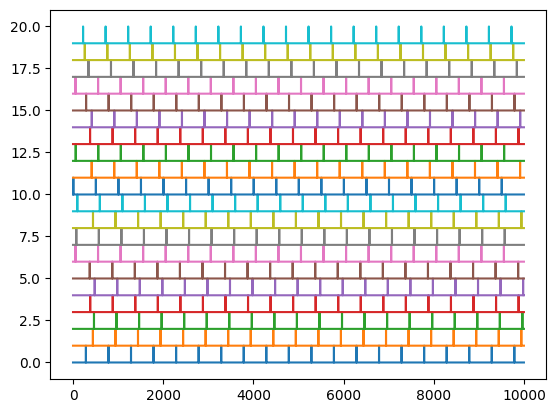

In [14]:
parameters['clock_sim']=1e-4
sim_time = 1
#generate set of randomly shifted inputs
spike_coll = []
for i in range(20):
    spike_coll_loc,_ = generate_freqs([20],trials_n=1,sim_time=sim_time,sampling_freq=1/parameters['clock_sim'],shift=1)
    spike_coll += spike_coll_loc

#flatten each set and split potential extra trials
spike_coll_clean = []
for i in range(len(spike_coll)):
    spike_coll_clean += torch.tensor_split(spike_coll[i].flatten(),spike_coll[i].shape[1],dim=0)

#do some magic I don't get
in_spikes_t = torch.stack(spike_coll_clean,dim=0)
in_spikes_t = in_spikes_t.T.unsqueeze(2)*torch.ones((1,1,parameters['neurons_n']))
sim_time = in_spikes_t.shape[0]*parameters['clock_sim']
in_spikes_t[in_spikes_t>0] = 1
in_spikes_t = in_spikes_t.to(parameters['device'])

#plot to show
for i in range(len(spike_coll_clean)):
    plt.plot(spike_coll_clean[i]+i)

In [15]:
#parameters
#parameters = {}
parameters['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parameters['device'] = torch.device("cpu")
print('device in use:', parameters['device'])
parameters['neurons_n'] = 50
parameters['frequencies'] = 1
parameters['C_Osc'] = 1
parameters['v_Osc_threshold'] = 1
parameters['tau_Osc_Ie'] = 5e-3
parameters['tau_Osc'] = 100e-3
parameters['TDE_to_Osc_current'] = 2
parameters['reset_osc'] = 0
parameters['I_minimum_osc'] = 24
parameters['I_step_osc'] = 0.1
parameters['refrac_Osc'] = 1e-3
parameters['C_TDE'] = 1
parameters['v_TDE_threshold'] = 1
parameters['tau_trg_TDE'] = 2.5e-3
parameters['tau_fac_TDE'] = 10e-3
parameters['gain_fac_TDE'] = 1
parameters['gain_trg_TDE'] = 10000
parameters['reset_TDE'] = 0
parameters['tau_TDE'] = 10e-3
parameters['refrac_TDE'] = 1e-3
parameters['trials_per_stimulus'] = 1

device in use: cpu


In [16]:
# plt.rcParams.update({'font.size': 15})
spk_tde_t,spk_osc_t,v_tde_t,v_osc_t,i_trg_t,i_fac_t,i_syn_t = sim_sPLL(in_spikes=in_spikes_t,freqs=[i for i in range(in_spikes_t.shape[1])],break_feedback = False,parameters_here=parameters,save_traces=True)
# plot_spll_run(in_spikes_t,spk_tde_t,spk_osc_t,i_syn_t,i_fac_t,i_trg_t,[],suptitle='Texture',cmap='Purples',xlims=[0,1000],moving_avg=10)

Simulating sPLL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4861.12it/s]


360
(300, 300, 4)


/tmp/ipykernel_102618/3927614689.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_102618/3927614689.py:249: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


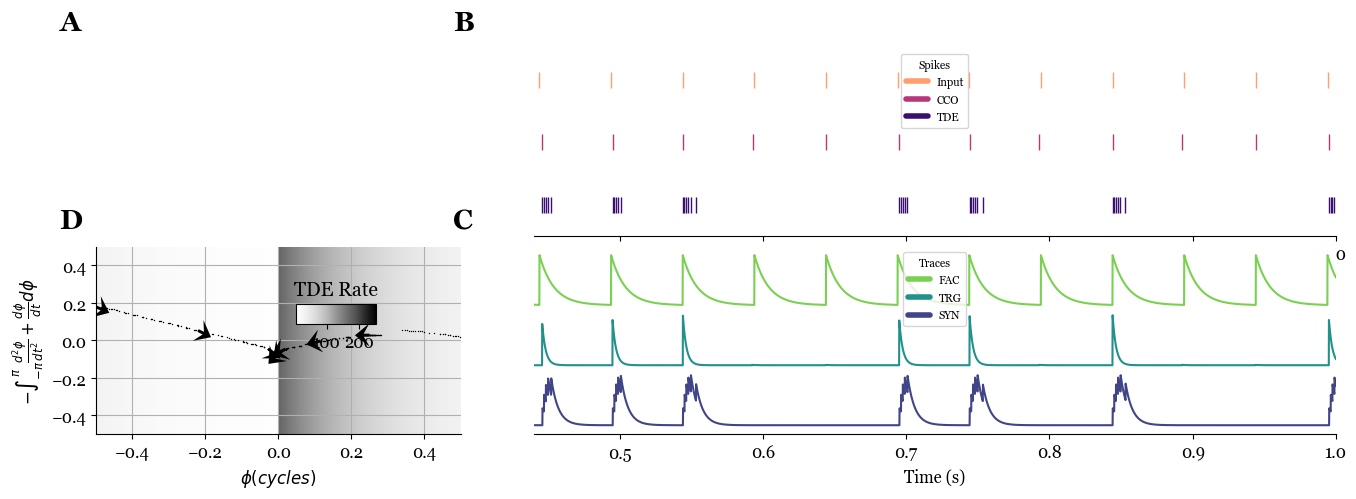

In [37]:
#working with offsets, now 3 for a paper
# plt.rcParams['text.usetex'] = True
# plt.rcParams.update({'font.size': 45})
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', family='Georgia', size=SMALL_SIZE)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#keep colors same as in other plots
colors = mpl.colormaps['magma'](np.linspace(0.2,0.8,3))

select_try_global = 13
select_shift = 1

#set up things, we don' t really use this for this plot
noruns = spk_osc_t.shape[2]
noshifts = spk_osc_t.shape[1]
skip = 1 #get every skip trace
# fig, axs = plt.subplots(2,2,figsize =(30,12),sharex=True, sharey=True)
fig1 = plt.figure(figsize=(16,5))
gs = fig1.add_gridspec(6, 3)
extspikes = np.argwhere(in_spikes_t.cpu()[:,0,0].numpy()).flatten()
period = np.average(np.diff(extspikes))*parameters['clock_sim'] #period for the wrapping
frequency = 1/period #freq for title
k = 0
letters = ['A','B','C','D','E','F','G']
axis1 = []
axis1.append(fig1.add_subplot(gs[0:3, 0]))
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].axis('off')
axis1.append(fig1.add_subplot(gs[0:3, 1:3]))
spikes_in = torch.where(in_spikes_t[:,select_shift,select_try_global])
spikes_tde = torch.where(spk_tde_t[:,select_shift,select_try_global])
spikes_osc = torch.where(spk_osc_t[:,select_shift,select_try_global])
colors = mpl.colormaps['magma'](np.linspace(0.2,0.8,3))
axis1[-1].plot(spikes_in[0]*parameters['clock_sim'],np.zeros_like(spikes_in[0])+2,'|',markersize=12,color=colors[2])
axis1[-1].plot(spikes_osc[0]*parameters['clock_sim'],np.zeros_like(spikes_osc[0])+1,'|',markersize=12,color=colors[1])
axis1[-1].plot(spikes_tde[0]*parameters['clock_sim'],np.zeros_like(spikes_tde[0]),'|',markersize=12,color=colors[0])
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
custom_lines = []
from matplotlib.lines import Line2D
custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
axis1[-1].legend(custom_lines,[
     'Input',
     'CCO',
    'TDE',
],fancybox=True,loc='best',title='Spikes', framealpha=0.8)
axis1[-1].spines['left'].set_visible(False)

axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
axis1[-1].set_xlim(4400*parameters['clock_sim'],10000*parameters['clock_sim'])
axis1[-1].set_ylim(-0.5,2.5)
# axis1[-1].set_xticks([])
axis1[-1].set_yticks([])


colors = mpl.colormaps['viridis'](np.linspace(0.2,0.8,3))
axis1.append(fig1.add_subplot(gs[3:6, 1:3]))
custom_lines = []
from matplotlib.lines import Line2D
custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
axis1[-1].legend(custom_lines,[
     'FAC',
     'TRG',
    'SYN',
],fancybox=True,loc='best',title='Traces', framealpha=0.8)
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_fac_t[:,select_shift,select_try_global]/i_fac_t.max()+2.4,color=colors[2])
axis1[-1].set_xlim(4400*parameters['clock_sim'],10000*parameters['clock_sim'])
axis1[-1].set_yticks([])
# axis1[-1].set_xticks([])
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')
axis1[-1].spines['left'].set_visible(False)
axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
# axis1[-1].set_yticks([])
axis1[-1].set_xlabel('Time (s)')
# axis1.append(fig1.add_subplot(gs[4, 1:3]))
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_trg_t[:,select_shift,select_try_global]/i_trg_t.max() + 1.2,color=colors[1])
# axis1[-1].set_xlim(0,10000)
# axis1[-1].set_xticks([])
# axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
#             size=20, weight='bold')

axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
# axis1.append(fig1.add_subplot(gs[5, 1:3]))
axis1[-1].plot(np.array([i for i in range(i_trg_t.shape[0])])*parameters['clock_sim'],i_syn_t[:,select_shift,select_try_global]/i_syn_t.max(),color=colors[0])
# axis1[-1].set_xlim(0,10000)
# axis1[-1].set_xticks([])
# axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
#             size=20, weight='bold')

axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
axis1.append(fig1.add_subplot(gs[3:, 0]))
selected_trials = [1,select_try_global,34]
selected_trials = [select_try_global]
axis1[-1].text(-0.1, 1.1, letters.pop(0), transform=axis1[-1].transAxes, 
            size=20, weight='bold')

axis1[-1].spines['right'].set_visible(False)
axis1[-1].spines['top'].set_visible(False)
for k,i in enumerate(selected_trials):
    #get axis, use a separate iterator because i is unreliable
#     ax = axs[1,1]
# )
    ax = axis1[-1]
    #set up arrays
    phase = np.empty(0)
    dphase = np.empty(0)
    ddphase = np.empty(0)

    #we loop through all our different shifts, so we can stick em together after
    for j in range(noshifts):
        #get spikes for both cco and input
        intspikes = np.argwhere(spk_osc_t[:,j,skip*i].numpy()).flatten()
        extspikes = np.argwhere(in_spikes_t.cpu()[:,j,skip*i].numpy()).flatten()
        
        #cut to size, such that we only look at the part where both are active
        lenint = len(intspikes)
        lenext = len(extspikes)
        if lenint>lenext:
            intspikes=intspikes[:lenext]
        elif lenext>lenint:
            extspikes=extspikes[:lenint]
        phaseloc = np.empty_like(extspikes)
        for n in range(len(extspikes)):
            phaseloc[n] = extspikes[n]

        #get loc(al) phase, dphase, and ddphase, add to global arrays
        phaseloc = (intspikes-extspikes)*parameters['clock_sim']
        phase = np.append(phase,phaseloc[1:-1])
        dphaseloc = np.diff(phaseloc)/period
        dphase = np.append(dphase,dphaseloc[1:])
        ddphaseloc = np.diff(dphaseloc)
        ddphase = np.append(ddphase,ddphaseloc)

    #'wrap' to -pi,pi
    phasefix = (((phase+period/2)%period)-period/2)/period
    psorting = np.argsort(phasefix)
    phasefix = phasefix[psorting]
    dphase = dphase[psorting]
    ddphase = ddphase[psorting]
    integddphase = integ.cumulative_trapezoid((dphase+ddphase)/period,x=phasefix,initial=0)
    integddphase -= np.average(integddphase)

    #create arrow arrays
    #first we set the step size, smaller for the locking plot
    if k == 2:
        arrowstep = 2
    else:
        arrowstep = 50

    #get x and y
    arrowx = phasefix[::arrowstep]
    arrowy = -integddphase[::arrowstep]

    #have it point the direction of movement
    arrowsign = (dphase/np.abs(dphase))[::arrowstep][:-1]*0.04#*scale

    #the tangent of the curve
    arrowu = np.diff(arrowx)
    arrowv = np.diff(arrowy)
    arrowsign /= np.sqrt(arrowu**2+arrowv**2)
    arrowu *= arrowsign
    arrowv *= arrowsign

    #locking plot becomes a mess near x=0
    if k == 2:
        arrowslice = np.abs(arrowx)>0.001
        arrowx = arrowx[arrowslice]
        arrowy = arrowy[arrowslice]
        arrowu = arrowu[arrowslice[:-1]]
        arrowv = arrowv[arrowslice[:-1]]

    #main curve
    print(len(phasefix))
    ax.scatter(phasefix,-integddphase,linewidth=0.001,color='k',zorder=4,s=1)

    #arrows
    ax.quiver(arrowx[:-1],arrowy[:-1],arrowu,arrowv,scale=1,width=0.1,minlength=0.01,headwidth=8,headaxislength=3,color='k',zorder=3)


    #shading
    pixels = 300
    half = int(pixels/2)
    grays = np.full((pixels,pixels, 4), 100, dtype=np.uint8)
    alphas = np.zeros((pixels,pixels,))
    
    alphas[:,half:] = 255*np.exp(-np.linspace(0,0.5,half)*period/parameters['tau_fac_TDE'])
    alphas[:,:half] = 255*np.exp(-np.linspace(0.5,1,half)*period/parameters['tau_fac_TDE'])
    grays[:,:,3] = alphas
    print(grays.shape)
    cm = ax.imshow(grays,extent=(-0.5, 0.5, -0.5, 0.8),zorder = 1,aspect='auto',cmap='Greys')
#     ax.imshow(grays)
    #make nice
    ax.set_ylim((-0.5,0.5))
#     ax.set_title(f"I = {parameters['I_minimum_osc']+parameters['I_step_osc']*i}")
    ax.grid()

#make whole plot nice
# plt.suptitle(f'Potential well plots with f = {frequency:.2f} Hz',size = 100)
axis1[-1].set_xlabel(r'$\phi (cycles)$')
axis1[-1].set_ylabel(r'$-\int^\pi_{-\pi} \frac{d^2\phi}{dt^2} +  \frac{d\phi}{dt}  d\phi$')
cbaxes = fig1.add_axes([0.25, 0.33, 0.05, 0.04])
cbaxes.set_title('TDE Rate')
# formatter = LogFormatter(10, labelOnlyBase=False)
import matplotlib.colors as colors_package
sm = plt.cm.ScalarMappable(cmap='Greys', norm=colors_package.Normalize(vmin=grays.min(), vmax=grays.max()))
fig1.colorbar(cm,cax=cbaxes, orientation='horizontal',cmap='Greys')
cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')
# cbaxes.set_yscale('log')
# cbaxes.set_yticks(tau_range[::2])
# cbaxes.set_yticklabels(np.round([int(tau_range[i]) for i in range(tau_range.shape[0])])[::-2])
# axis1.append(fig1.add_subplot(gs[2:4,3]))
# custom_lines = []
# from matplotlib.lines import Line2D
# custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[0], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[1], lw=4,solid_capstyle='round'))
# custom_lines.append(Line2D([0], [0], color=colors[2], lw=4,solid_capstyle='round'))
# axis1[-1].axis('off')
# axis1[-1].legend(custom_lines,[
#    'Linear',
#      'Input Spikes',
#      'CCO Spikes',
#     'TDE Spikes',
#     'FAC Trace',
#     'TRG Trace',
#     'SYN Trace'
# ],fancybox=True,loc='best',title='Model', framealpha=0.8)
plt.tight_layout()
fig1.savefig('Fig2.svg')
plt.show()

In [24]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_cache = [i for i in
    fm.findSystemFonts(fontpaths=None, fontext='ttf')
    if 'TTF' in i]
for i in font_cache:
    print(i)

fontman = fm.FontManager()
fontman.findfont(fm.FontProperties(family='Georgia'))

/usr/share/fonts/TTF/Comicbd.TTF
/usr/share/fonts/TTF/Arialbd.TTF
/usr/share/fonts/TTF/Arial.TTF
/usr/share/fonts/TTF/Arialbi.TTF
/usr/share/fonts/TTF/trebuc.ttf
/usr/share/fonts/TTF/couri.ttf
/usr/share/fonts/TTF/trebucbi.ttf
/usr/share/fonts/TTF/Georgiab.TTF
/usr/share/fonts/TTF/courbd.ttf
/usr/share/fonts/TTF/cour.ttf
/usr/share/fonts/TTF/Timesbd.TTF
/usr/share/fonts/TTF/trebucit.ttf
/usr/share/fonts/TTF/Webdings.TTF
/usr/share/fonts/TTF/Ariali.TTF
/usr/share/fonts/TTF/Trebucbd.ttf
/usr/share/fonts/TTF/SymbolsNerdFont-Regular.ttf
/usr/share/fonts/TTF/Verdanaz.TTF
/usr/share/fonts/TTF/Impact.TTF
/usr/share/fonts/TTF/Verdanab.TTF
/usr/share/fonts/TTF/courbi.ttf
/usr/share/fonts/TTF/Georgia.TTF
/usr/share/fonts/TTF/Georgiaz.TTF
/usr/share/fonts/TTF/Verdanai.TTF
/usr/share/fonts/TTF/AndaleMo.TTF
/usr/share/fonts/TTF/Georgiai.TTF
/usr/share/fonts/TTF/Times.TTF
/usr/share/fonts/TTF/Timesbi.TTF
/usr/share/fonts/TTF/Verdana.TTF
/usr/share/fonts/TTF/Comic.TTF
/usr/share/fonts/TTF/Timesi.TTF


'/usr/share/fonts/TTF/Georgia.TTF'